# Assignment 3
## Question 1: Siamese networks & one-shot learning (8pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much less examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [1]:
# === add code here ===
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

c:\users\illia\appdata\local\conda\conda\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
#check gpu is working
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [2]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("")


y_train

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)



array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [3]:
#sort label, get the indices
sort_p=np.argsort(y_train.flatten(),axis=None)

In [4]:
#rearrange training data based on sort
x_train_new=[x_train[sort_p[i]].flatten() for i in range(50000)]
y_train_new=[y_train[sort_p[i]].flatten() for i in range(50000)]

In [5]:
#reshape train data
x_train_new2=np.reshape(x_train_new,(100, 500, 32, 32, 3))
y_train_new2=np.reshape(y_train_new,(100, 500, 1))

In [6]:
#take first 80 class as trining and last 20 as testing dataset
x_train_final=x_train_new2[0:80]
y_train_final=y_train_new2[0:80]
x_test_final=x_train_new2[80:]
y_test_final=y_train_new2[80:]

In [7]:

c_train={a:a for a in range(80)}
c_test={a:a for a in range(80,100)}

print("X_train shape:", x_train_final.shape)
print("")
print("training alphabets")
print([key for key in c_train.keys()])

c_test

X_train shape: (80, 500, 32, 32, 3)

training alphabets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


{80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 91: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99}

In [8]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    #n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=32, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [11]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 128)         512       
__________

In [7]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    #if language is not None:
        #low, high = c[language]
        #if N > high - low:
        #    raise ValueError("This language ({}) has less than {} letters".format(language, N))
    #    categories = np.random.choice(range(low,high), size=(N,), replace=False)
    #else:  # if no language specified just pick a bunch of random letters
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)    
    #print(categories)
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [8]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [11]:
pairs, targets = make_oneshot_task(20, x_train_final, c_train, language=5)
#plot_oneshot_task(pairs)

In [20]:
import h5py
#import h5py_cache as h5c
h5py.run_tests()

.....................................................x...............................s...................................x....................................s...s......ss.ss............................................................................ss...................ssssss..............................F..................................x....x........................x.....x.................................................ssss.........F....
FAIL: test_out_of_order_offsets (h5py.tests.old.test_h5t.TestCompound)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\users\illia\appdata\local\conda\conda\envs\tensorflow-gpu\lib\site-packages\h5py\tests\old\test_h5t.py", line 61, in test_out_of_order_offsets
    self.assertEqual(tid.dtype, expected_dtype)
AssertionError: dtype[13 chars]1','f3','f2'], 'formats':['<f4','<f8','<i4'], [30 chars]:20}) != dtype[13 chars]1','f2','f3'], 'formats':['<f4','<i4','<f8'], [30 chars]:20})



<unittest.runner.TextTestResult run=446 errors=0 failures=2>

In [29]:
loops = 250
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train_final)
    test_acc = test_oneshot(siamese_net, x_test_final, c_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 4s 36ms/step - loss: 0.6819
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6797
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6899
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6803
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-

100/100 [==============================] - 3s 33ms/step - loss: 0.6715
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 71 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6658
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 72 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6769
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 73 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6838
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 74 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 

100/100 [==============================] - 3s 33ms/step - loss: 0.6756
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 106 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6858
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 107 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6732
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 108 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6656
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
=== Training loop 109 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - los

100/100 [==============================] - 3s 33ms/step - loss: 0.6758
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 141 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6784
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 142 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6665
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 143 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6681
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.6% accuracy for 20-way one-shot learning
=== Training loop 144 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - los

100/100 [==============================] - 3s 33ms/step - loss: 0.6650
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 176 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6807
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 177 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6729
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 178 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6716
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.6% accuracy for 20-way one-shot learning
=== Training loop 179 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

100/100 [==============================] - 3s 33ms/step - loss: 0.6667
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 211 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6640
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 212 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6604
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 213 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6701
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.8% accuracy for 20-way one-shot learning
=== Training loop 214 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

100/100 [==============================] - 3s 34ms/step - loss: 0.6685
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.2% accuracy for 20-way one-shot learning
=== Training loop 246 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6655
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 17.6% accuracy for 20-way one-shot learning
=== Training loop 247 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6694
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 248 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6689
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.4% accuracy for 20-way one-shot learning
=== Training loop 249 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

In [30]:
print('Best acc: ',best_acc)

Best acc:  22.4


***

**b)** Briefly motivate your model's architecture, as well as its performance. What accuracy would random guessing achieve (on average)?

**Answer:**

*=== write your answer here ===*

***

**c)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

*=== write your answer here ===*

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [11]:
input_shape = (32, 32, 3)


# build model to use in each siamese 'leg'
model = Sequential()
model.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(80, activation="sigmoid", kernel_regularizer=l2(1e-3)))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 128)         512       
__________

In [89]:
batch_size = 100
epochs = 20

model.fit(x_train_cnn, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 15s 422us/step - loss: 4.1107 - acc: 0.0871 - val_loss: 8.0275 - val_acc: 0.0000e+00
Epoch 2/20
36000/36000 [==============================] - 12s 346us/step - loss: 3.6313 - acc: 0.1593 - val_loss: 8.4507 - val_acc: 0.0000e+00
Epoch 3/20
36000/36000 [==============================] - 13s 348us/step - loss: 3.1829 - acc: 0.2383 - val_loss: 8.3306 - val_acc: 0.0000e+00
Epoch 4/20
36000/36000 [==============================] - 12s 347us/step - loss: 2.9109 - acc: 0.2988 - val_loss: 8.2229 - val_acc: 0.0000e+00
Epoch 5/20
36000/36000 [==============================] - 12s 347us/step - loss: 2.7229 - acc: 0.3431 - val_loss: 8.5603 - val_acc: 0.0000e+00
Epoch 6/20
36000/36000 [==============================] - 13s 348us/step - loss: 2.5955 - acc: 0.3747 - val_loss: 8.4642 - val_acc: 0.0000e+00
Epoch 7/20
36000/36000 [==============================] - 12s 347us/step - loss: 2.5128 - acc

In [90]:
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.0494189372062683
Test accuracy: 0.418625


In [91]:
model.save(os.path.join("models", "cnn_80_second_0418.h5"))

In [16]:
# additional imports
from keras.models import load_model
from keras.models import Model
model = load_model(os.path.join("models", "cnn_80_second_0418.h5"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 6, 6, 128)         512       
__________

In [17]:
# load the previously trained and saved models
#model = load_model(os.path.join("models", "cnn_80_second_0418.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
model_nc = Model(inputs=model.input, outputs=model.get_layer("conv2d_20").output)

# obtain flat representations of the data
#x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
#x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
#pca = PCA(n_components=128)
#pca.fit(x_train_r_flat)

x_train_cnn_flat=x_train_cnn.reshape((x_train_cnn.shape[0], -1))
x_test_cnn_flat=x_test_cnn.reshape((x_test_cnn.shape[0], -1))

# obtain 128-dimensional representations
nc_train = model_nc.predict(x_train_cnn_flat)
#nc_test = model_nc.predict(x_test_cnn)


# print the shapes to confirm all features are 128-dimensional
print(nc_train.shape)
#print(nc_test.shape)

ValueError: Error when checking : expected conv2d_17_input to have 4 dimensions, but got array with shape (40000, 3072)

In [19]:
nc_test = model_nc.predict(x_test_cnn)
print(nc_test.shape)

(10000, 1, 1, 256)


In [20]:
def l2dist(a,b):
    return np.linalg.norm(a-b)

In [18]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# properties of the data
img_rows, img_cols, chns = 32, 32, 3
n_classes = 100

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

#classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [19]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 80).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 80).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 80).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 80).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :80]
y_train_r = y_train_r[:, 80:]
y_test_l = y_test_l[:, :80]
y_test_r = y_test_r[:, 80:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(80000, 32, 32, 3)
(20000, 32, 32, 3)
(80000, 80)
(20000, 20)
(80000, 1)
(20000, 1)
(16000, 32, 32, 3)
(4000, 32, 32, 3)
(16000, 80)
(4000, 20)
(16000, 1)
(4000, 1)


In [38]:
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,name="neural_codes_cnn_1"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name="neural_codes_cnn_2"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(128, name="neural_codes_cnn_3"))
cnn.add(Dense(80, activation='softmax',name="neural_codes_cnn_4"))
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_codes_cnn_1 (Conv2D)  (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
neural_codes_cnn_2 (Conv2D)  (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
__________

In [39]:
batch_size = 100
epochs = 20
cnn.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
72000/72000 [==============================] - 35s 490us/step - loss: 2.3316 - acc: 0.5773 - val_loss: 1.8153 - val_acc: 0.5881
Epoch 2/20
72000/72000 [==============================] - 33s 455us/step - loss: 1.3875 - acc: 0.6572 - val_loss: 1.5275 - val_acc: 0.6331
Epoch 3/20
72000/72000 [==============================] - 33s 453us/step - loss: 1.2024 - acc: 0.6910 - val_loss: 1.4784 - val_acc: 0.6349
Epoch 4/20
72000/72000 [==============================] - 33s 453us/step - loss: 1.0986 - acc: 0.7140 - val_loss: 1.4825 - val_acc: 0.6373
Epoch 5/20
72000/72000 [==============================] - 33s 453us/step - loss: 1.0201 - acc: 0.7309 - val_loss: 1.3397 - val_acc: 0.6657
Epoch 6/20
72000/72000 [==============================] - 33s 454us/step - loss: 0.9488 - acc: 0.7466 - val_loss: 1.3034 - val_acc: 0.6711
Epoch 7/20
72000/72000 [==============================] - 33s 454us/step - loss: 0.8854 - acc: 0.7614 - val_loss: 1.2

In [24]:
loss, accuracy = cnn.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.0107322149276734
Test accuracy: 0.6729375


In [41]:
# save the model
cnn.save(os.path.join("models", "cnn.h5"))

In [92]:
# load the previously trained and saved models
cnn = load_model(os.path.join("models", "cnn.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes_cnn_3").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set

# obtain 128-dimensional representations
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)

# print the shapes to confirm all features are 128-dimensional
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)


(20000, 128)
(4000, 128)


In [93]:
from sklearn.neighbors import NearestNeighbors
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [94]:
def show_img(filepath):
    img = Image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [38]:
print(x_train_r.shape)

(20000, 32, 32, 3)


Index list: [1006  242   28  776  728 2788]


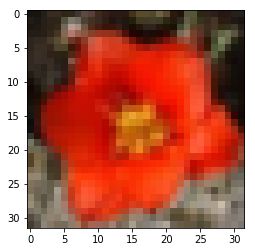

class= 12


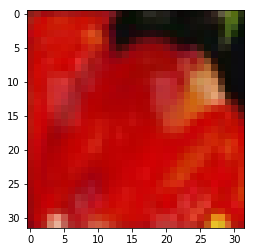

class= 3


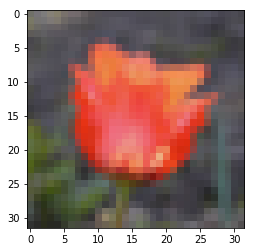

class= 12


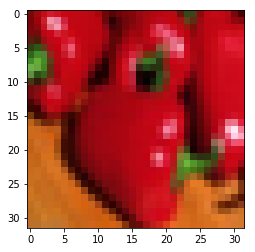

class= 3


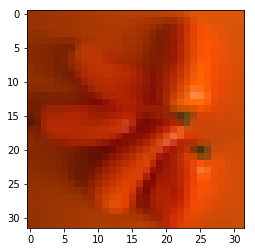

class= 3


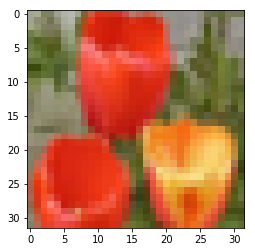

class= 12
Index list: [1444 3726  516 2692 2706 3356]


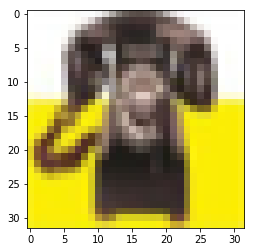

class= 6


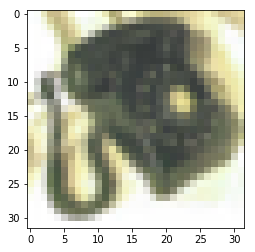

class= 6


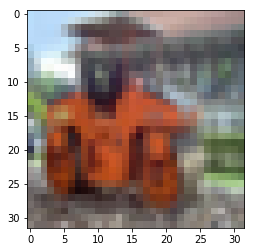

class= 9


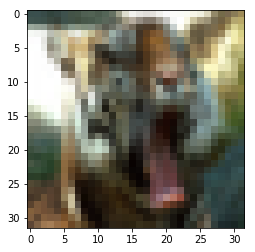

class= 8


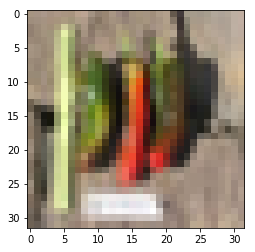

class= 3


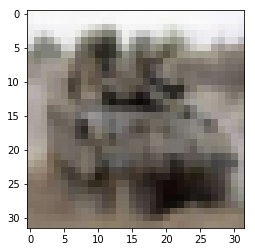

class= 5
Index list: [ 750 1852 1982 3446 3414 2428]


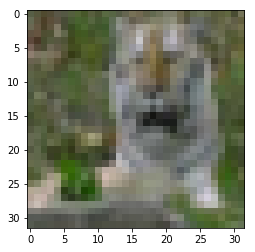

class= 8


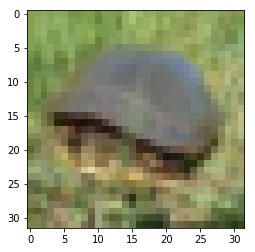

class= 13


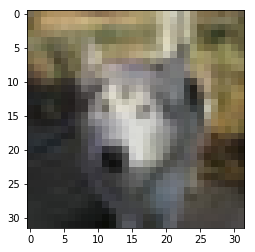

class= 17


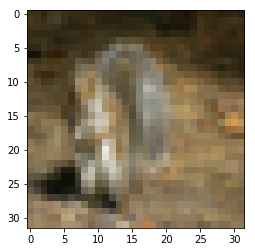

class= 0


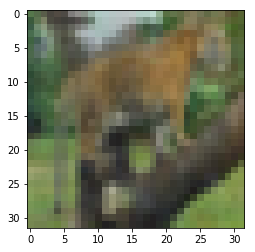

class= 8


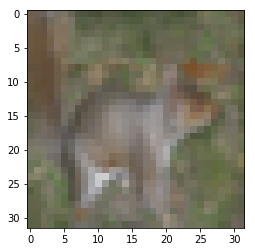

class= 0
Index list: [ 344 3096  124 1510 2528  468]


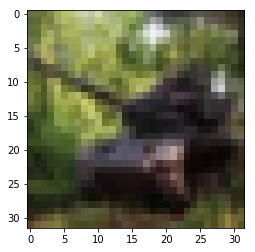

class= 5


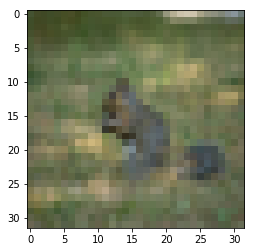

class= 0


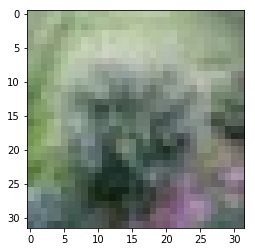

class= 16


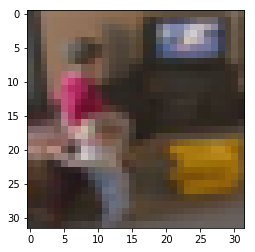

class= 7


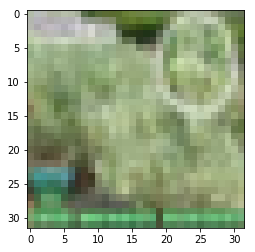

class= 16


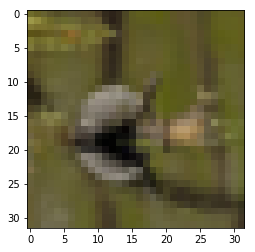

class= 13
Index list: [705 921 923 707  11  99]


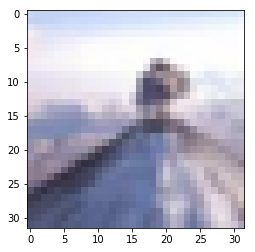

class= 0


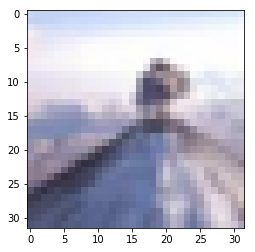

class= 0


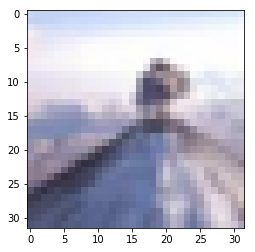

class= 0


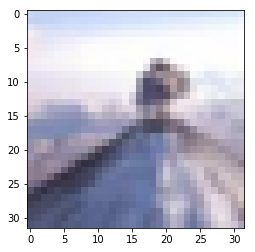

class= 0


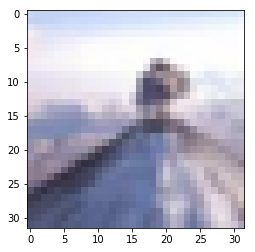

class= 0


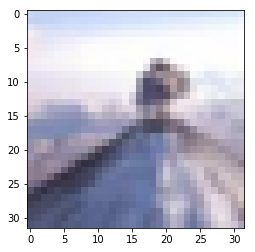

class= 0


In [108]:
# make random selection of n query images/indices, the same for all experiments
def uniq(x):
    return len(x) == len(set(x))

n = 200
n_examples = 2000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)
result={}
shown=set()

representations = [
    (nc_cnn_train, nc_cnn_test),
]

it=0
idt=['cnn']
for (nc_train, nc_test) in representations:
    # === SOLUTION: ===
    #print(nc_test.shape)
# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
#for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
    # load the dataset
    #with open(os.path.join("data", datapath), "rb") as f:
        #X_train_digits_r, y_train_digits_r, X_test_digits_r, y_test_digits_r = pickle.load(f)
        #X_fc, y, X_paths, classes = pickle.load(f)

    #nsamples, nx, ny = nc_test.shape
    # === SOLUTION: ===
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    #nc_test_rs=nc_test.reshape((n_examples,nx*ny))
    neigh.fit(nc_test)
    X_fc = nc_test[indices]
    
    nn = neigh.kneighbors(X_fc)
    #print(nn[0].shape)
    #print(nn[0])
    #print(nn[1].shape)
    #print(nn[1])
    
    cnt=0
    for i in range(len(nn[0])):
        if(np.sum(nn[0][i]==0) and uniq(nn[1][i]) and not nn[1][i][0] in shown):
            print("========================================================")
            print("Index list:",nn[1][i])
            for j in range(6):
                plt.imshow(x_test_r[(nn[1][i][j])])
                plt.show()
                print('class=',np.argmax(y_test_r[(nn[1][i][j])]))
                cnt+=1
                shown.add(nn[1][i][j])
        #if(cnt%3==0 and cnt>0):
            
        if(cnt==30):
            break

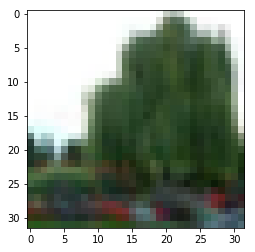

In [60]:

#from PIL import Image
plt.imshow(x_train_r[1000])

In [ ]:
# load the dataset

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

neigh = NearestNeighbors(n_neighbors=6, p=2)
neigh.fit(X_fc)

examples ={0:None,1:None,2:None,3:None,4:None,5:None}
# === SOLUTION: ===
for i in range(len(X_fc)):
    nn = neigh.kneighbors(X_fc[i].reshape(1,-1))[1][0]
    not_similar = [x for x in nn if y[x] != y[nn[0]]]
    if examples[len(not_similar)] == None:
        examples[len(not_similar)] = {'score':len(not_similar),'img':X_fc[i],'class':classes[y[i]],'path':X_paths[i]}
    #print("progress: {} \r".format((i/len(X_fc))))
    if None in examples.values():
        continue
    else:
        break

for i in range(6):
    print("Score achieved {}".format(examples[i]['score']))
    show_img(examples[i]['path'])


***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

*=== write your answer here ===*